 # Project


## Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns

## Dummy Submission (All-Positive)

In [2]:
def dummy_submit():
    submission_df = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')
    submission_df['Transported'] = True
    submission_df.to_csv('submission.csv', index=False)
    
# This is dummy, not real submit, comment out when you don't want dummy
# dummy_submit()

## Data Exploration

In [3]:
train_df = pd.read_csv('../input/spaceship-titanic/train.csv')
test_df = pd.read_csv('../input/spaceship-titanic/test.csv') # Does NOT contain y -> 'Transported'

viewFull = pd.concat([train_df, test_df]) # for viewing the number of missing cells

In [4]:
viewFull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


In [5]:
viewFull.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

It looks like there's some columns with missing values that we'll have to fill.

### Transported

Text(0.5, 1.0, 'Transported rate')

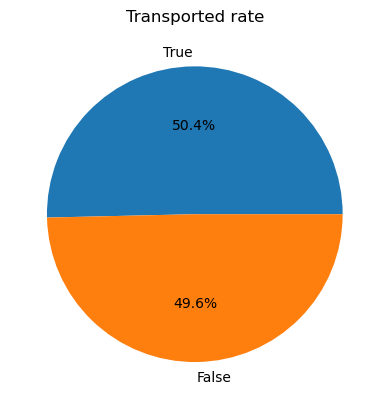

In [6]:
data = train_df['Transported'].value_counts()
plt.pie(data, labels=data.index, autopct='%1.1f%%')
plt.title('Transported rate')

### Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck (Numerical)

In [7]:
to_hist = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

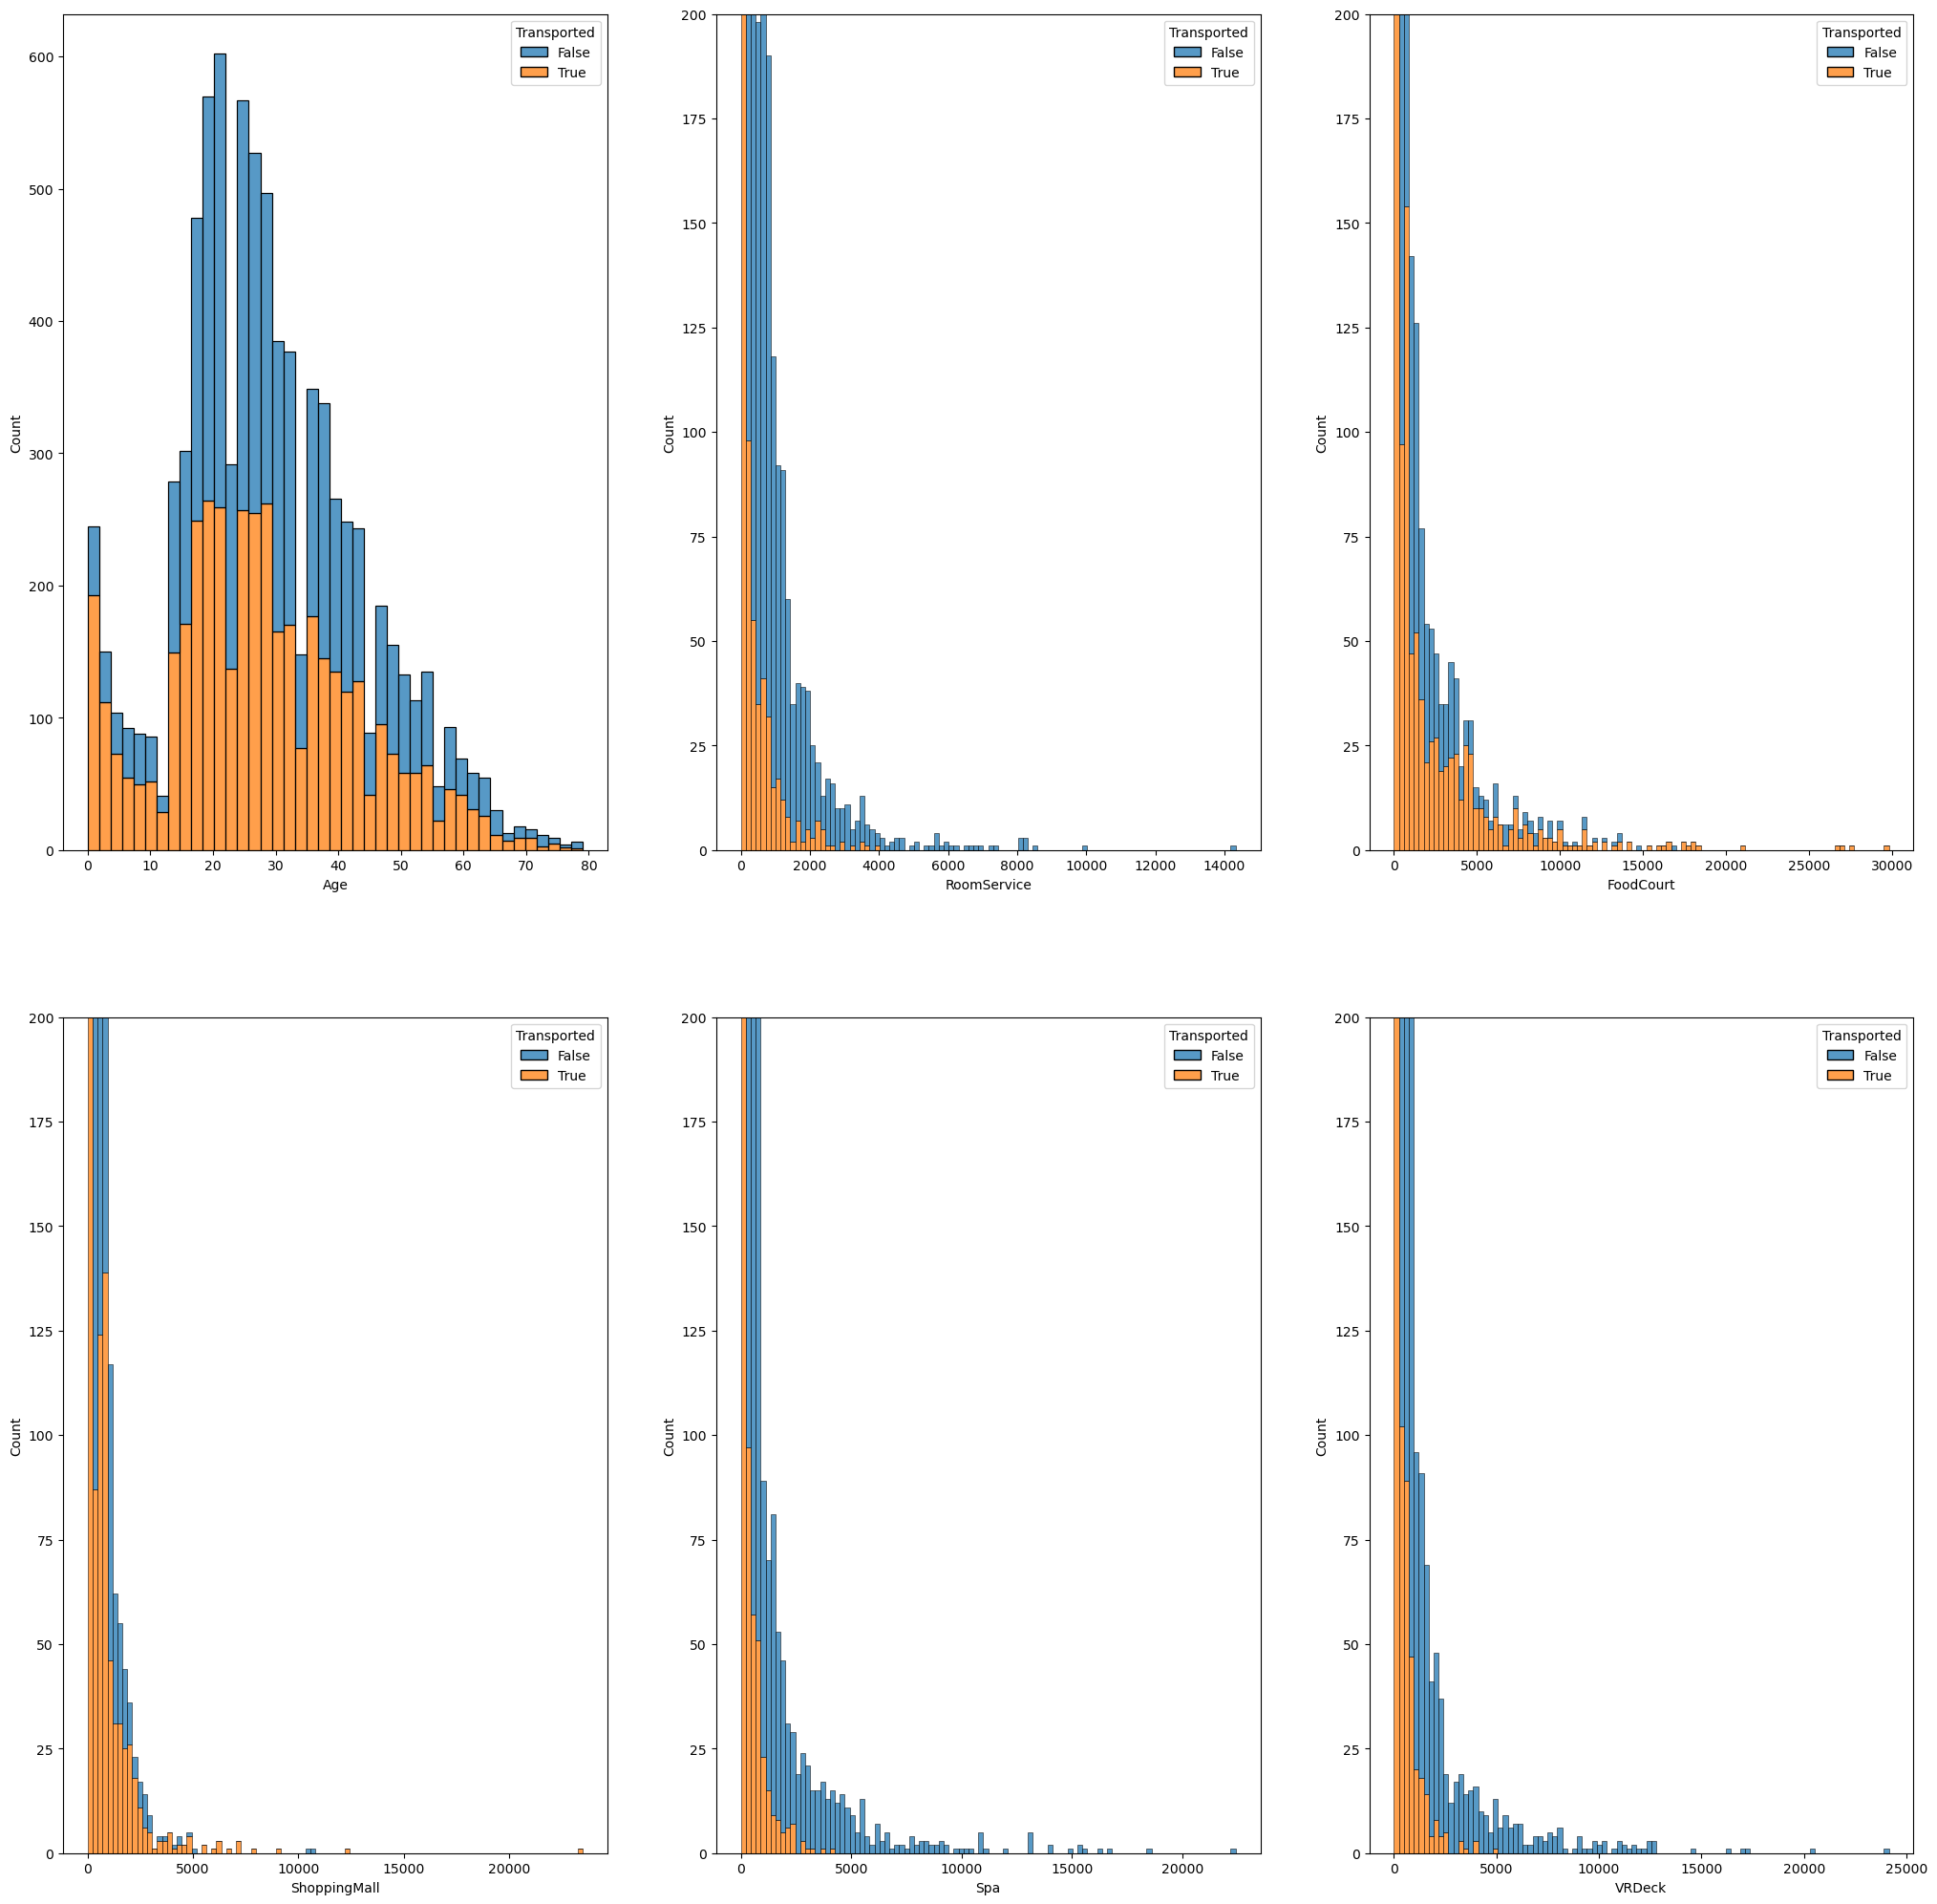

In [8]:
fig, axes = plt.subplots(2,3, figsize=(25,25))

for i in range(2):
    for j in range(3):
        idx = (i*3)+j
        
        if (idx > 0):
            sns.histplot(x=to_hist[idx], hue='Transported', multiple='stack', data=train_df, ax=axes[i, j], bins=100)
            axes[i, j].set_ylim(0, 200)

        else:
            sns.histplot(x=to_hist[idx], hue='Transported', multiple='stack', data=train_df, ax=axes[i, j])

plt.show()   

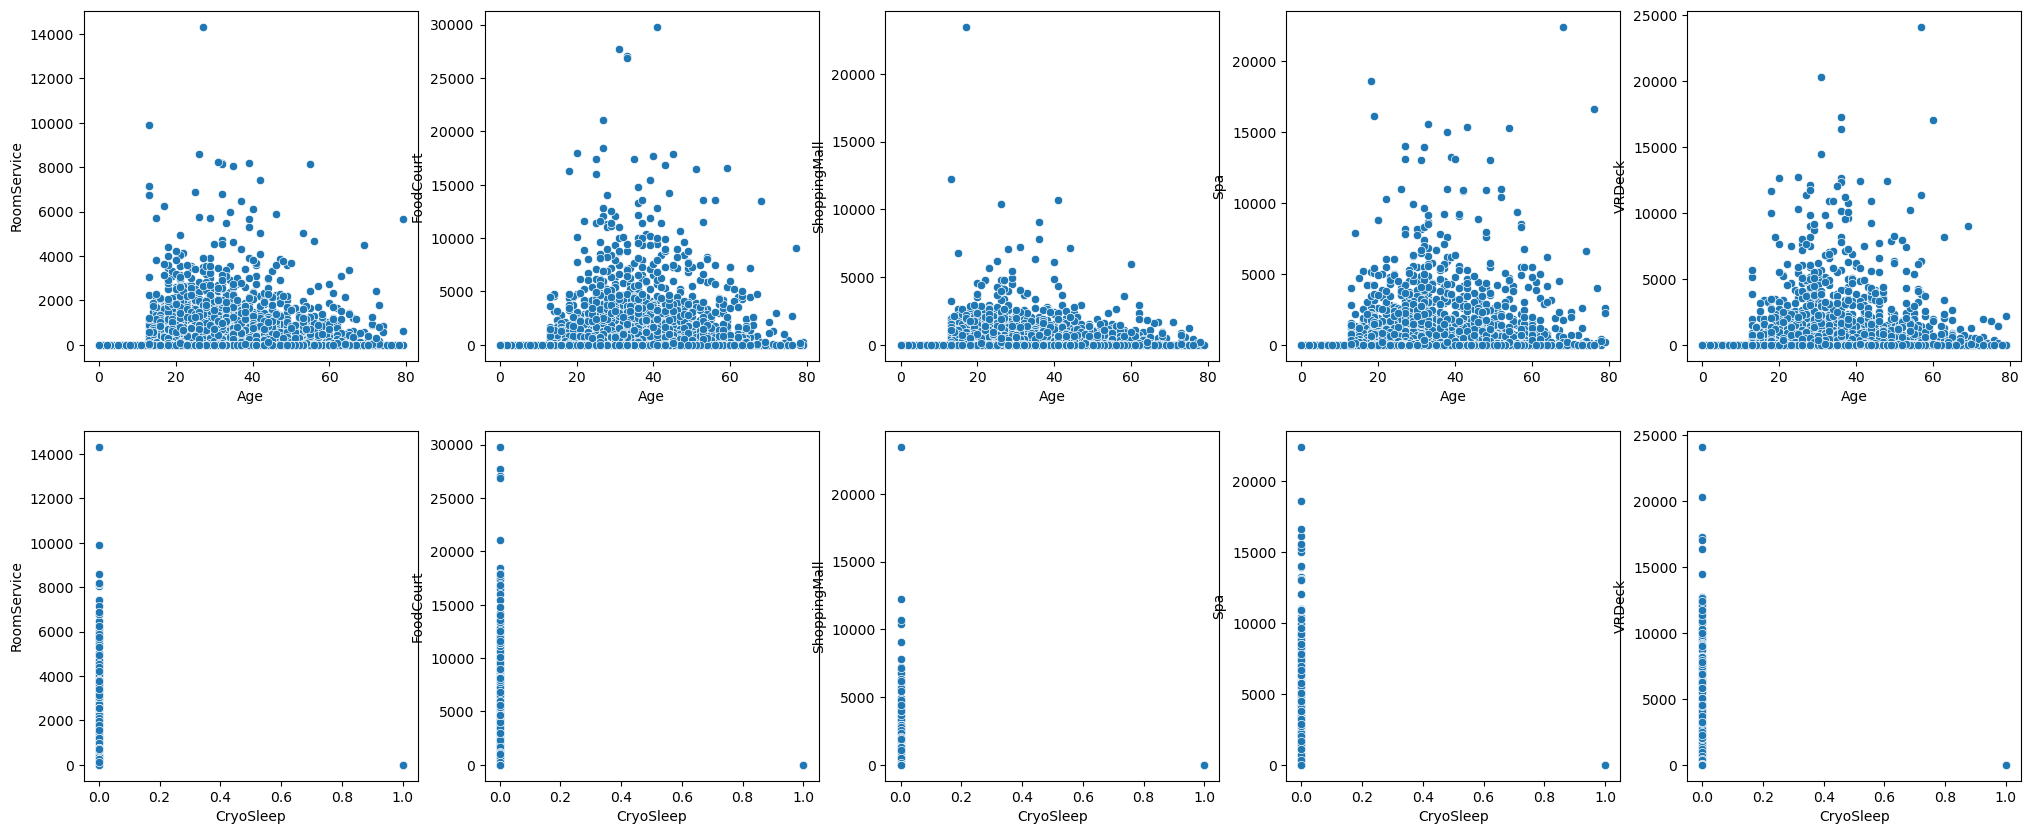

In [9]:
to_scatter = to_hist[1:]
scatterX = ["Age", "CryoSleep"]

fig, axes = plt.subplots(2, 5, figsize=(25, 10))

for i in range(2):
    for j in range(5):
        sns.scatterplot(x=scatterX[i], y=to_scatter[j], data=train_df, ax=axes[i, j])

<Axes: xlabel='Age', ylabel='Count'>

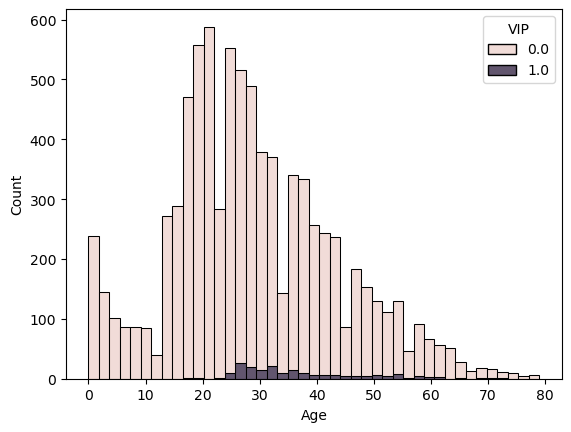

In [10]:
sns.histplot(x="Age", hue="VIP", multiple='stack', data=train_df)

Here's some interesting things we learned:
- Nobody under the age of 13 spent any money
    - if a passenger's age is known to be <=13, then we can fill any missing money values in to be 0
- Nobody in cryosleep spent any money
    - if a passenger is known to be in cryosleep, then we can fill any missing money values in to be 0
    - if a passenger has spent any money, then we can fill any missing CryoSleep values in to be False
- Nobody under the age of 18 is a VIP
    - if a passenger's age is known to be <=18, then we can fill any missing VIP values in to be False

### HomePlanet, CryoSleep, Destination, VIP (Categorical)

In [11]:
to_bar = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

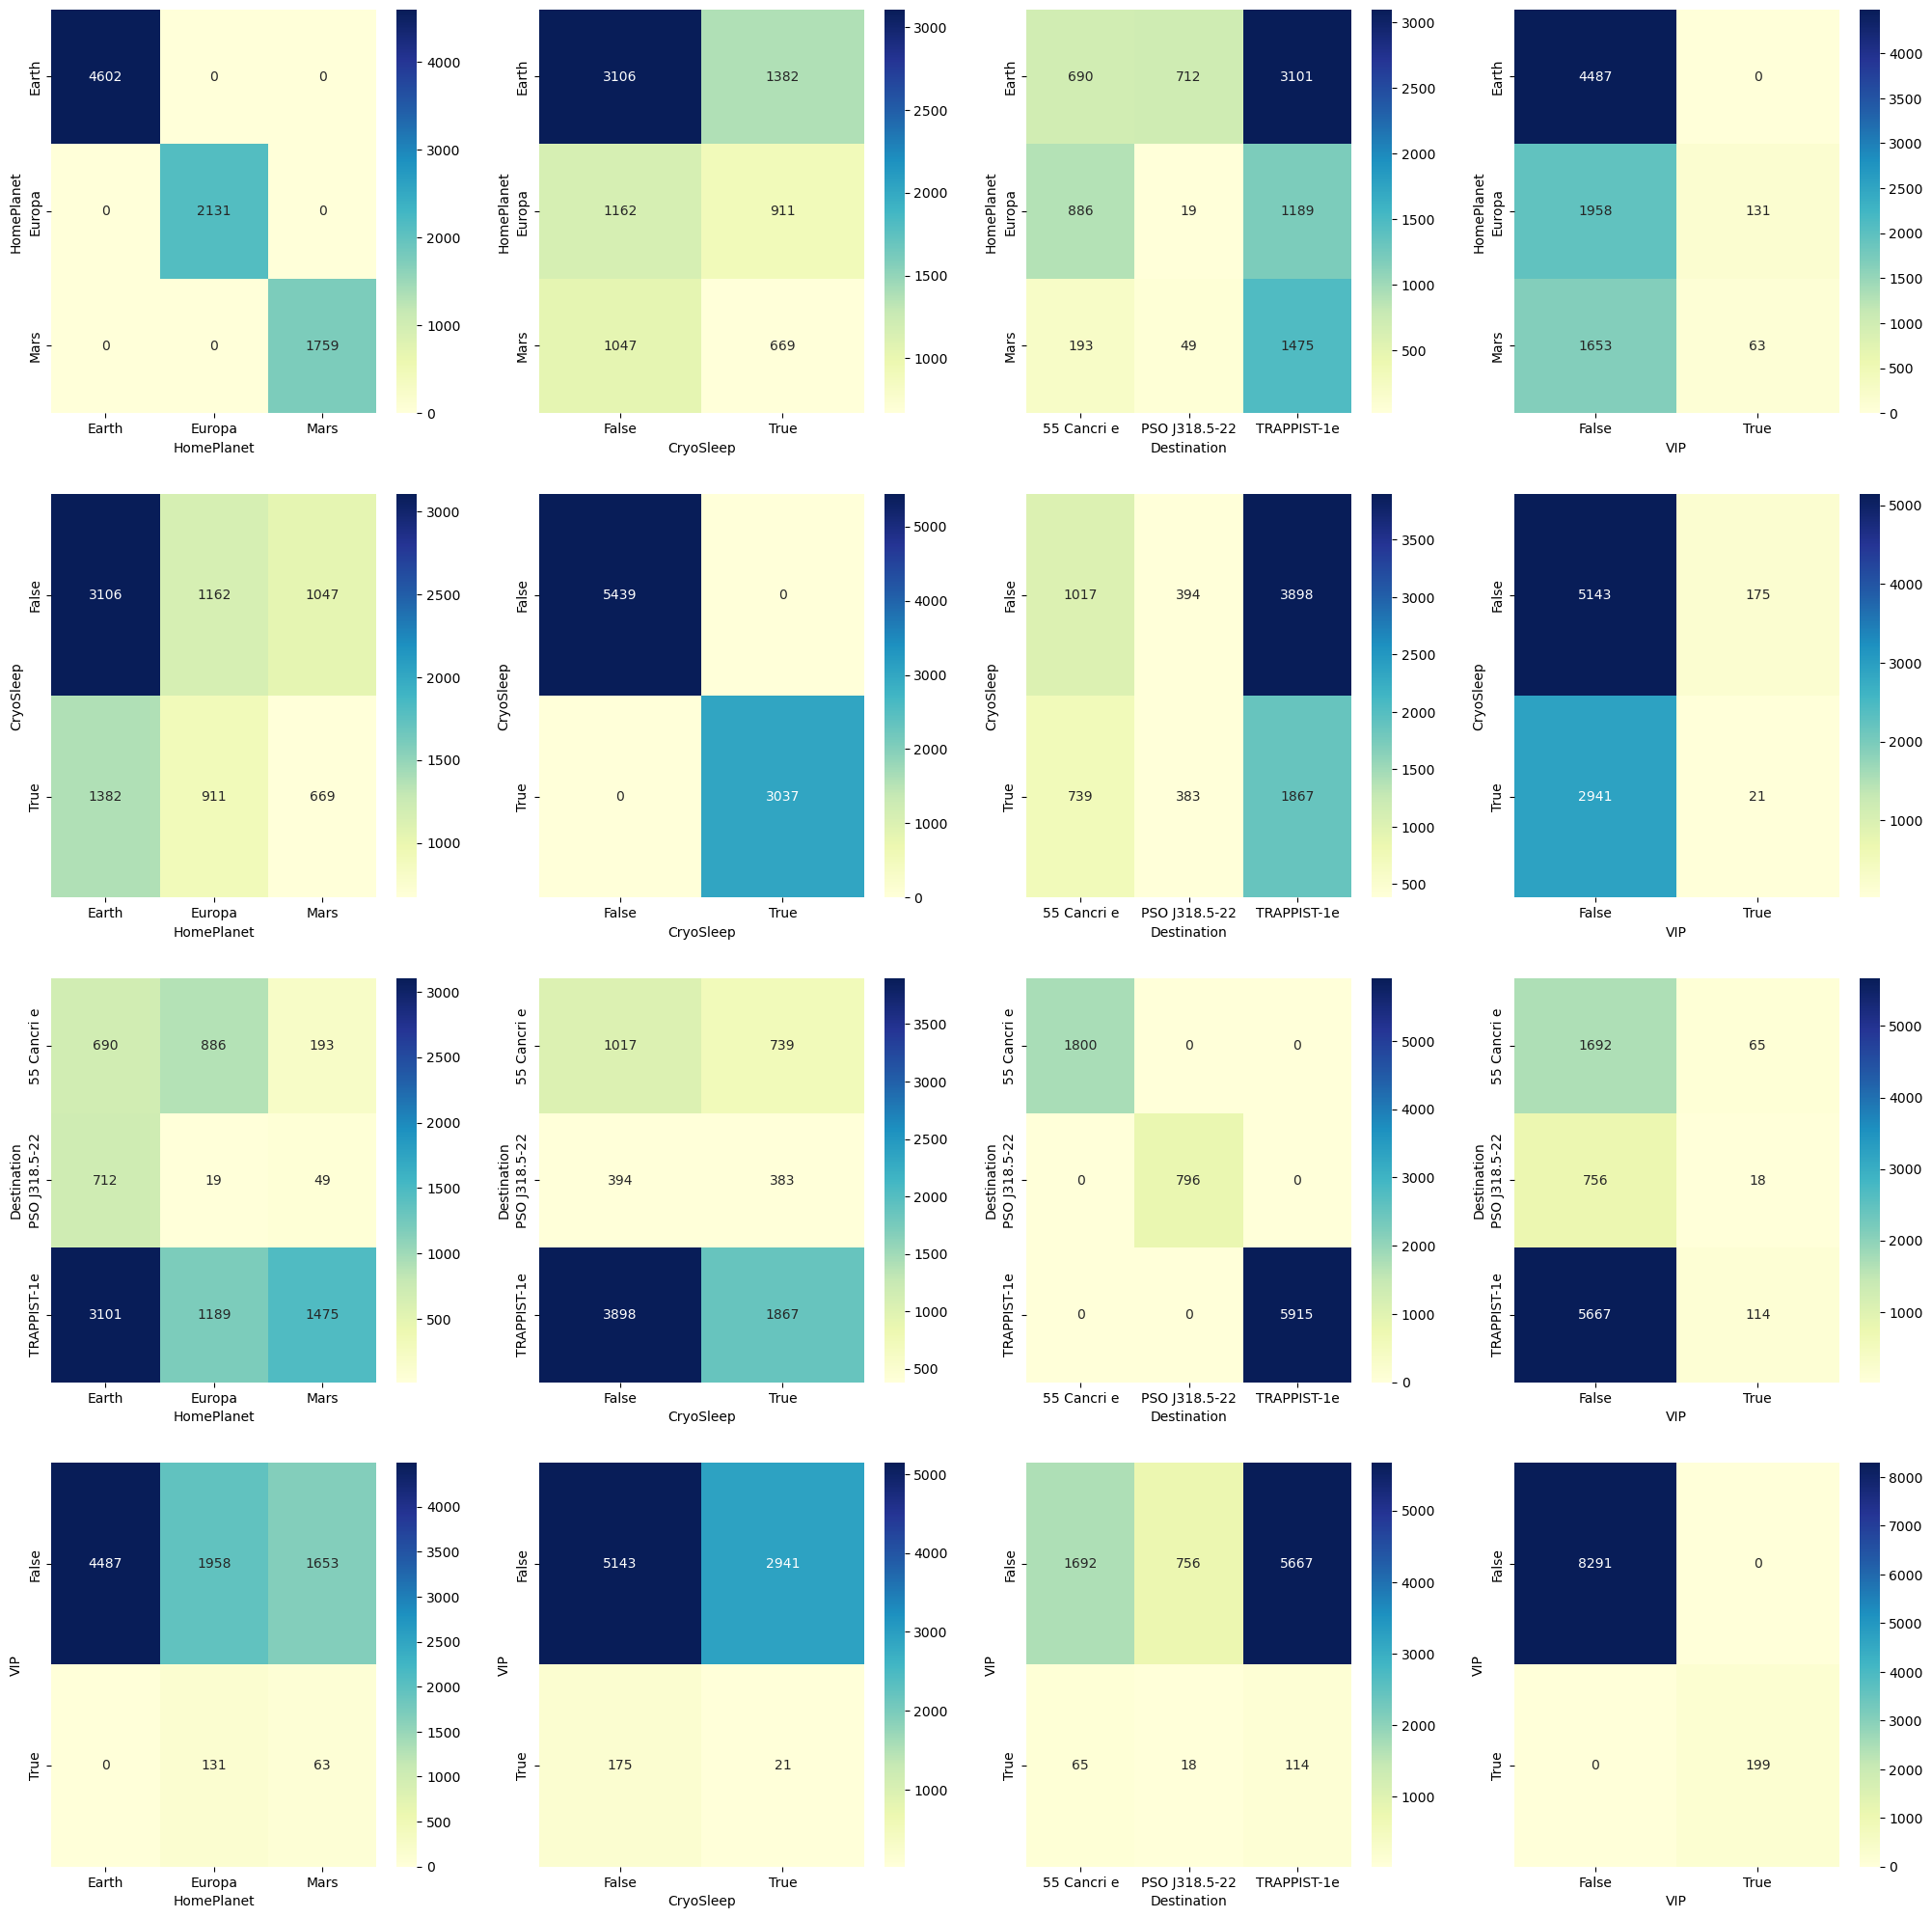

In [12]:
fig, axes = plt.subplots(4, 4, figsize=(25,25))

for i in range(4):
    for j in range(4):
        cross_tab = pd.crosstab(train_df[to_bar[i]], train_df[to_bar[j]])
        sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='g', cbar=True, ax=axes[i, j])
plt.show()

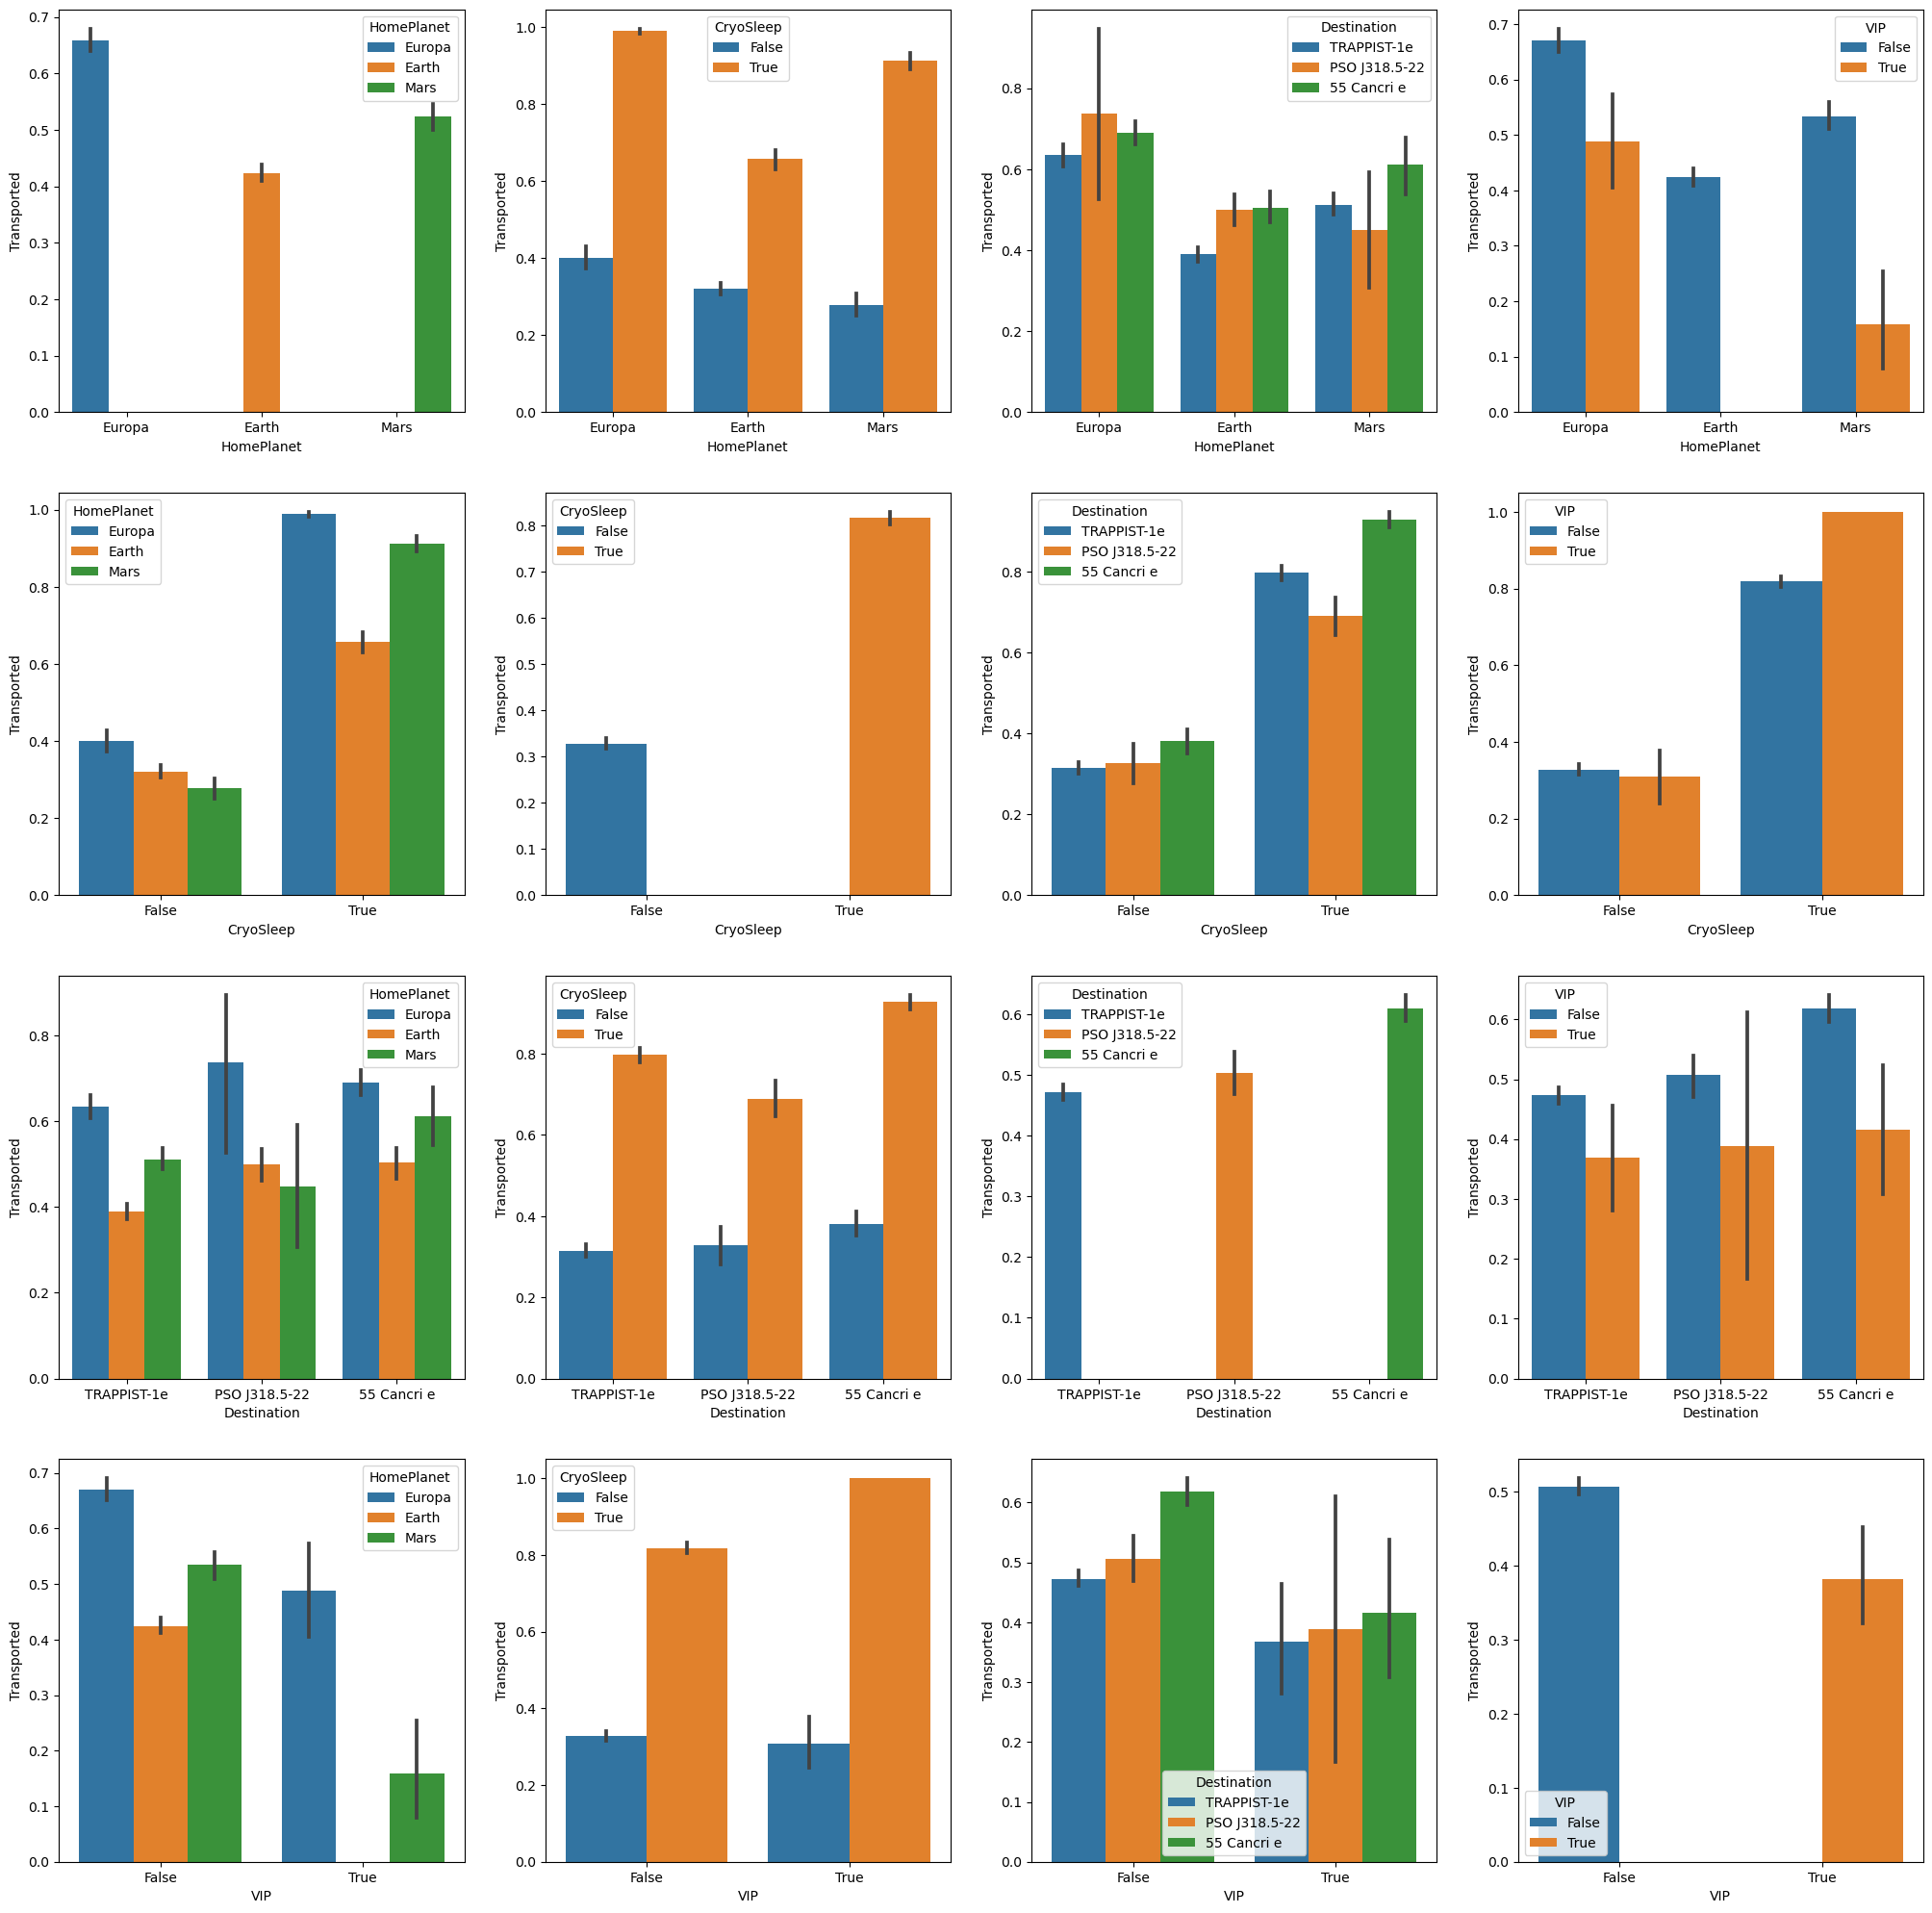

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(25,25))

for i in range(4):
    for j in range(4):
        sns.barplot(x=to_bar[i], y="Transported", hue=to_bar[j], data=train_df, ax=axes[i, j])
        # axes[i,j].legend().set_visible(False)
plt.show()

Here's some interesting things we learned:
- Nobody on Earth is a VIP even though they are the most populous group
    - If a passenger is known to have come from earth, then we can fill any missing values of VIP to be False

### Cabin, Name (Distinct)

In [14]:
for var in ['Cabin', 'Name']:
    distinct_count = len(viewFull[var].unique())
    print(f"Distinct count of {var}: {distinct_count}")

Distinct count of Cabin: 9826
Distinct count of Name: 12630


# Pre-processing

In [15]:
# Replaces whitespace with NaN
train_df.replace(r'^\s+$', np.nan, regex=True) 
test_df.replace(r'^\s+$', np.nan, regex=True)

def splitData(dataframe):
    # Split "PassengerId" into "GroupId" & "IndividualId"
    dataframe["GroupId"] = dataframe["PassengerId"].str.split("_").str[0]
    dataframe["IndividualId"] = dataframe["PassengerId"].str.split("_").str[1]

    dataframe["GroupId"] = pd.to_numeric(dataframe["GroupId"], errors="ignore", downcast="integer")
    dataframe["IndividualId"] = pd.to_numeric(dataframe["IndividualId"], errors="ignore", downcast="integer")

    # Split "Cabin" into "Deck", "Number", & "Side"
    dataframe["Deck"] = dataframe["Cabin"].str.split("/").str[0]
    dataframe["Number"] = dataframe["Cabin"].str.split("/").str[1]
    dataframe["Side"] = dataframe["Cabin"].str.split("/").str[2]

    dataframe.shape
    dataframe.sort_index()

    return dataframe

train_df = splitData(train_df)
test_df = splitData(test_df)

In [16]:
numeric_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "GroupId", "Number"] 
categorical_features = ["HomePlanet", "Destination", "Deck", "CryoSleep", "VIP", "Side"]
drop_features = ["Name", "PassengerId", "Cabin", "IndividualId"]  # do not include these features in modeling
passthrough_features = [] # do not apply any transformation

target = "Transported"

X_train = train_df.drop(columns=[target, *drop_features])
y_train = train_df[target]

X_test = test_df.drop(columns=[*drop_features]) # test_df does NOT contain target

In [17]:
def fillVIP(dataframe):
    BEFORE = dataframe["VIP"].isnull().sum() # The print statement below doesn't like this inside it.
    print(f"Number of empty VIP cells BEFORE: { BEFORE }")

    # No passenger under the age 18 is a VIP
    ageVIPIndex = dataframe[(dataframe["VIP"].isnull() == True) & (dataframe["Age"] < 18)][["VIP"]].index
    # dataframe["VIP"][ageVIPIndex] = False
    for idx in ageVIPIndex:
        dataframe.at[idx, "VIP"] = False

    # No passenger from Earth is a VIP
    earthVIPIndex = dataframe[(dataframe["VIP"].isnull() == True) & (dataframe["HomePlanet"] == "Earth")][["VIP"]].index
    # dataframe["VIP"][earthVIPIndex] = False
    for idx in earthVIPIndex:
        dataframe.at[idx, "VIP"] = False

    AFTER = dataframe["VIP"].isnull().sum()
    print(f"Number of empty VIP cells AFTER: { AFTER }")

In [18]:
def fillGroup(dataframe):
    HPBEFORE = dataframe["HomePlanet"].isnull().sum()
    DESTBEFORE = dataframe["Destination"].isnull().sum()
    print(f"Number of empty HomePlanet cells BEFORE: { HPBEFORE }")
    print(f"Number of empty Destination cells BEFORE: { DESTBEFORE }")

    # A passenger in a group will have the same HomePlanet and Destination as everyone else in their group
    homePlanetIndex = dataframe[(dataframe["HomePlanet"].isnull() == True)].index
    destinationIndex = dataframe[(dataframe["Destination"].isnull() == True)].index

    for i in homePlanetIndex:
        if (dataframe["GroupId"][i] == dataframe["GroupId"][i-1]):
            dataframe.at[i, "HomePlanet"] = dataframe.at[i-1, "HomePlanet"]
        elif (dataframe["GroupId"][i] == dataframe["GroupId"][i+1]):
            dataframe.at[i, "HomePlanet"] = dataframe.at[i+1, "HomePlanet"]
    for i in destinationIndex:
        if (dataframe["GroupId"][i] == dataframe["GroupId"][i-1]):
            dataframe.at[i, "Destination"] = dataframe.at[i-1, "Destination"]
        elif (dataframe["GroupId"][i] == dataframe["GroupId"][i+1]):
            dataframe.at[i, "Destination"] = dataframe.at[i+1, "Destination"]        

    # A passenger in a group will have the same Cabin as everyone else in their group
    DECKBEFORE = dataframe["Deck"].isnull().sum()
    print(f"Number of empty Cabin cells BEFORE: { DECKBEFORE }")
    
    deckIndex = dataframe[(dataframe["Deck"].isnull() == True)].index

    for i in deckIndex:
        if (dataframe["GroupId"][i] == dataframe["GroupId"][i-1]):
            dataframe.at[i, "Deck"] = dataframe.at[i-1, "Deck"]
            dataframe.at[i, "Number"] = dataframe.at[i-1, "Number"]
            dataframe.at[i, "Side"] = dataframe.at[i-1, "Side"]
        elif (dataframe["GroupId"][i] == dataframe["GroupId"][i+1]):
            dataframe.at[i, "Deck"] = dataframe.at[i+1, "Deck"]
            dataframe.at[i, "Number"] = dataframe.at[i+1, "Number"]
            dataframe.at[i, "Side"] = dataframe.at[i+1, "Side"]            
    
    HPAFTER = dataframe["HomePlanet"].isnull().sum()
    DESTAFTER = dataframe["Destination"].isnull().sum()
    DECKAFTER = dataframe["Deck"].isnull().sum()
    print(f"Number of empty HomePlanet cells AFTER: { HPAFTER }")
    print(f"Number of empty Destination cells AFTER: { DESTAFTER }")
    print(f"Number of empty Cabin cells AFTER: { DECKAFTER }")

In [19]:
def fillSpend(df):
    CRYOBEFORE = df["CryoSleep"].isnull().sum()
    print(f"Number of empty CryoSleep cells BEFORE: { CRYOBEFORE }")

    # If people are spending, they are not asleep
    isNotAsleep = df[(df["CryoSleep"].isnull() == True) & (
            (df["Spa"] > 0) | 
            (df["RoomService"] > 0) | 
            (df["FoodCourt"] > 0) | 
            (df["VRDeck"] > 0) | 
            (df["ShoppingMall"] > 0)) 
        ].index
    # df["CryoSleep"][isNotAsleep] = False
    for idx in isNotAsleep:
        df.at[idx, "CryoSleep"] = False
    
    CRYOAFTER = df["CryoSleep"].isnull().sum()
    print(f"Number of empty CryoSleep cells AFTER: { CRYOAFTER }")

    # If people are aspleep, they are spending 0 money
    stores = ["Spa", "RoomService", "FoodCourt", "VRDeck", "ShoppingMall"]
    filledNull = 0
    for store in stores:
        storeBEFORE = df[store].isnull().sum()
        print(f"Number of empty { store } cells BEFORE: { storeBEFORE }")

        isAsleep = df[(df["CryoSleep"] == True) & (df[store].isnull() == True) ].index
        filledNull += isAsleep.shape[0]
        # df[store][isAsleep] = 0
        for idx in isAsleep:
            df.at[idx, store] = 0

        storeAFTER = df[store].isnull().sum()
        print(f"Number of empty { store } cells AFTER: { storeAFTER }")

    # print(f"There are {df["CryoSleep"].isnull().sum()} null values left in sleep")
    print(f"Filled {filledNull} null spendings")

    # A passenger under the age of 13 won't have any money
    for store in stores:
        spendIndex = df[(df[store].isnull() == True) & (df["Age"] < 13)].index
        # df[store][spendIndex] = 0
        for idx in isAsleep:
            df.at[idx, store] = 0

In [20]:
X_trainCPY = X_train.copy()
X_testCPY = X_test.copy()

fillVIP(X_trainCPY)
fillGroup(X_trainCPY)
fillSpend(X_trainCPY)

fillVIP(X_testCPY)
fillGroup(X_testCPY)
fillSpend(X_testCPY)

Number of empty VIP cells BEFORE: 203
Number of empty VIP cells AFTER: 76
Number of empty HomePlanet cells BEFORE: 201
Number of empty Destination cells BEFORE: 182
Number of empty Cabin cells BEFORE: 199
Number of empty HomePlanet cells AFTER: 111
Number of empty Destination cells AFTER: 103
Number of empty Cabin cells AFTER: 99
Number of empty CryoSleep cells BEFORE: 217
Number of empty CryoSleep cells AFTER: 98
Number of empty Spa cells BEFORE: 183
Number of empty Spa cells AFTER: 118
Number of empty RoomService cells BEFORE: 181
Number of empty RoomService cells AFTER: 113
Number of empty FoodCourt cells BEFORE: 183
Number of empty FoodCourt cells AFTER: 113
Number of empty VRDeck cells BEFORE: 188
Number of empty VRDeck cells AFTER: 126
Number of empty ShoppingMall cells BEFORE: 208
Number of empty ShoppingMall cells AFTER: 112
Filled 361 null spendings
Number of empty VIP cells BEFORE: 93
Number of empty VIP cells AFTER: 49
Number of empty HomePlanet cells BEFORE: 87
Number of em

### Create Column Transformer

In [21]:
preprocessor = make_column_transformer(
    (make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy="median"),
        StandardScaler() 
        ), numeric_features 
    ),
    (make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy="most_frequent"), 
        OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        ), categorical_features
    ),
    remainder='passthrough'  # Keep non-transformed columns
)

In [22]:
pipeline = make_pipeline(preprocessor, SVC())

pipeline.fit(X_train, y_train)

pipeline.score(X_train, y_train)

0.8170942137351892

Best parameters for SVC: {'svc__C': 1.0, 'svc__gamma': 0.1}
Best parameters for Logistic Regression: {'lr__C': 1.0}
Best parameters for Random Forest: {'rf__max_depth': None, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
Best parameters for KNN: {'knn__n_neighbors': 9, 'knn__weights': 'uniform'}


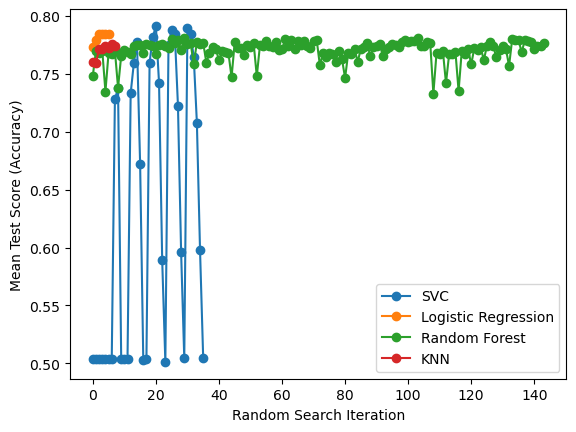

In [23]:
svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC()) 
])

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lr', LogisticRegression(max_iter=1000)) 
])

# Able to memorize training set with unlimited max depth
from sklearn.ensemble import RandomForestClassifier
rf_pipeline  = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier()) 
])



from sklearn.neighbors import KNeighborsClassifier
knn_pipeline  = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier()) 
])


# ===== Random Param Search on Each =====
# Define the parameter grids for each model
svc_param_dist = {
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

logreg_param_dist = {
    'lr__C': [0.001, 0.01, 0.1, 1.0, 10, 100]
}

rf_param_dist = {
    'rf__n_estimators': [10, 50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

knn_param_dist = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']
}

def random_search_and_plot(model, param_dist, name, X, y):
    random_search = GridSearchCV(model, param_dist, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
    random_search.fit(X, y)

    print(f"Best parameters for {name}: {random_search.best_params_}")

    # Plot the validation scores
    plt.plot(random_search.cv_results_['mean_test_score'], marker='o', label=name)
    return random_search.best_estimator_

# Perform RandomizedSearchCV and plot for each model
svc = random_search_and_plot(svc_pipeline, svc_param_dist, 'SVC', X_train, y_train)
lr = random_search_and_plot(lr_pipeline, logreg_param_dist, 'Logistic Regression', X_train, y_train)
rf = random_search_and_plot(rf_pipeline, rf_param_dist, 'Random Forest', X_train, y_train)
knn = random_search_and_plot(knn_pipeline, knn_param_dist, 'KNN', X_train, y_train)

# Display the plot
plt.xlabel('Random Search Iteration')
plt.ylabel('Mean Test Score (Accuracy)')
plt.legend()
plt.show()

In [24]:
models = [('svc', Pipeline([('prep', preprocessor), ('svc', SVC(C=1, gamma=.1))])), 
          ('lr', Pipeline([('prep', preprocessor), ('logreg', LogisticRegression(C=10, max_iter=1000))])), 
          ('rf', Pipeline([('prep', preprocessor), ('rf', RandomForestClassifier(max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=100))])), 
          ('knn', Pipeline([('prep', preprocessor), ('knn', KNeighborsClassifier(n_neighbors=9, weights='uniform'))])), 
]
# for name, model in models:
#     scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
#     print(f"{name} - Mean Accuracy: {np.mean(scores)}, Std: {np.std(scores)}")
from sklearn.ensemble import VotingClassifier, StackingClassifier
weights = [1, 1, 1, 1]

voting_classifier = VotingClassifier(models, weights=weights, voting='hard')
voting_classifier.fit(X_train, y_train)
print(voting_classifier.score(X_train, y_train))

voting_classifier = VotingClassifier(models, voting='hard')

# Define the parameter grid for the weights
param_grid = {
    'weights': [
        [1, 1, 1, 1],  # Equal weights
        [2, 1, 1, 1],  
        [1, 2, 1, 1],  
        [1, 1, 2, 1],  
        [1, 1, 1, 2],  
        [2, 2, 1, 1],  
        [2, 1, 2, 1],  
        [2, 1, 1, 2],  
        [2, 3, 1, 1],  
        [3, 2, 1, 1],  
        [1, 2, 1, 2],  
        # Add more weight combinations as needed
    ]
}

# Perform grid search to find the best weights

grid_search = GridSearchCV(voting_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display the best parameters and corresponding accuracy
print("Best parameters for ensemble:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)
best_voting = grid_search.best_estimator_


# Choose a meta-classifier (e.g., Logistic Regression)
meta_classifier = LogisticRegression(max_iter=1000)

# Create the stacking classifier
stacking_classifier = StackingClassifier(estimators=models, final_estimator=meta_classifier)

# Define the parameter grid for the stacking classifier
param_grid = {
    'final_estimator__C': np.logspace(-3, 3, 7),  # Adjust the parameter for the meta-classifier
    'stack_method': ['auto']  # 'auto' uses the method based on the type of estimator
}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(stacking_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display the best parameters and corresponding accuracy
print("Best parameters for stacking ensemble:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)
best_stacking = grid_search.best_estimator_

0.85252502013114
Best parameters for ensemble: {'weights': [2, 3, 1, 1]}
Best accuracy: 0.7950104917247389
Best parameters for stacking ensemble: {'final_estimator__C': 0.01, 'stack_method': 'auto'}
Best accuracy: 0.79593042838397


In [25]:
from sklearn.model_selection import GridSearchCV, learning_curve

grid = make_pipeline(preprocessor, SVC())

param_grid = {
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(
    grid, param_grid, cv=5, n_jobs=-1, return_train_score=True
)

grid_search.fit(X_train, y_train)

print(f"best score: {grid_search.best_score_}")
print(f"best params: {grid_search.best_params_}")

results_df = pd.DataFrame(grid_search.cv_results_)
heatmap_data = results_df.pivot(index='param_svc__C', columns='param_svc__gamma', values='mean_test_score')
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=5, n_jobs=-1
)

best score: 0.7910984117824947
best params: {'svc__C': 1.0, 'svc__gamma': 0.1}


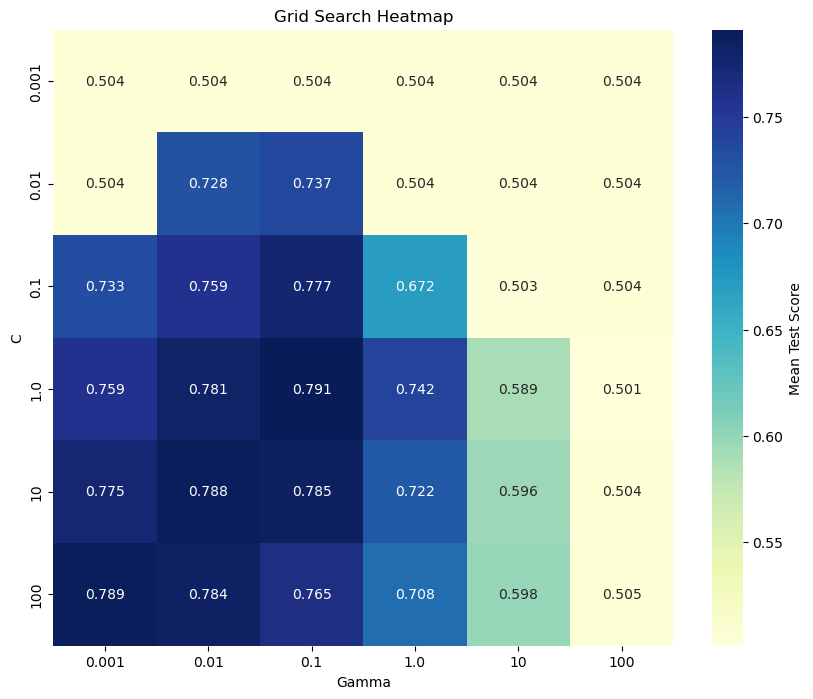

In [26]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f", cbar_kws={'label': 'Mean Test Score'})
plt.title('Grid Search Heatmap')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.show()

Using default SVC() due to it having a better test score than anything from GridSearch

In [27]:
# y_pred = grid_search.best_estimator_.predict(X_test)

testpipeline = make_pipeline(preprocessor, SVC())

testpipeline.fit(X_trainCPY, y_train)
y_pred = testpipeline.predict(X_testCPY)

submission_df = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')
submission_df['Transported'] = y_pred
submission_df.to_csv('submission.csv', index=False)